# Data Preparation

In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dir = '../data/'
data = pd.read_csv(dir+'train_weather.csv')

In [4]:
data.dtypes

RowId                          int64
IntersectionId                 int64
Latitude                     float64
Longitude                    float64
EntryStreetName               object
ExitStreetName                object
EntryHeading                  object
ExitHeading                   object
Hour                           int64
Weekend                        int64
Month                          int64
Path                          object
TotalTimeStopped_p20           int64
TotalTimeStopped_p40           int64
TotalTimeStopped_p50           int64
TotalTimeStopped_p60           int64
TotalTimeStopped_p80           int64
TimeFromFirstStop_p20          int64
TimeFromFirstStop_p40          int64
TimeFromFirstStop_p50          int64
TimeFromFirstStop_p60          int64
TimeFromFirstStop_p80          int64
DistanceToFirstStop_p20      float64
DistanceToFirstStop_p40      float64
DistanceToFirstStop_p50      float64
DistanceToFirstStop_p60      float64
DistanceToFirstStop_p80      float64
C

In [5]:
data.columns

Index([u'RowId', u'IntersectionId', u'Latitude', u'Longitude',
       u'EntryStreetName', u'ExitStreetName', u'EntryHeading', u'ExitHeading',
       u'Hour', u'Weekend', u'Month', u'Path', u'TotalTimeStopped_p20',
       u'TotalTimeStopped_p40', u'TotalTimeStopped_p50',
       u'TotalTimeStopped_p60', u'TotalTimeStopped_p80',
       u'TimeFromFirstStop_p20', u'TimeFromFirstStop_p40',
       u'TimeFromFirstStop_p50', u'TimeFromFirstStop_p60',
       u'TimeFromFirstStop_p80', u'DistanceToFirstStop_p20',
       u'DistanceToFirstStop_p40', u'DistanceToFirstStop_p50',
       u'DistanceToFirstStop_p60', u'DistanceToFirstStop_p80', u'City',
       u'Cityid', u'CenterDistance', u'DailySnowDepth', u'DailySnowfall',
       u'HourlyDewPointTemperature', u'HourlyDryBulbTemperature',
       u'HourlyPrecipitation', u'HourlyVisibility',
       u'HourlyWetBulbTemperature', u'HourlyWindSpeed', u'DaylightTime'],
      dtype='object')

In [53]:
X = data.drop(['RowId','EntryStreetName','Path',
       'ExitStreetName','TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80'],axis=1)

In [54]:
y = data[['TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80']]

In [55]:
y = data['TotalTimeStopped_p20'].values

In [56]:
# onehot encoding
X_1 = X[['Cityid','EntryHeading', 'ExitHeading','Hour', 'Weekend',
       'Month']]
le = preprocessing.LabelEncoder()
X_2 = X_1.apply(le.fit_transform)
enc = preprocessing.OneHotEncoder()
enc.fit(X_2)
X_enc = enc.transform(X_2).toarray()

In [57]:
X = X.drop(['IntersectionId','EntryHeading','ExitHeading','City'], axis=1).values
X = np.c_[X_enc,X]

In [58]:
# remove nan, infinite
X_t = X[ ~np.isnan(X).any(axis=1), :]
y_t = y[~np.isnan(X).any(axis=1)]
X_clean = X_t[ np.isfinite(X_t).any(axis=1), :]
y_clean = y_t[ np.isfinite(X_t).any(axis=1)]

In [63]:
# scaling
scaler =preprocessing.MinMaxScaler()
scaler.fit(X_clean)
X_clean = scaler.transform(X_clean)

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [65]:
# reshape feature matrix
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_train.shape

(375228, 70, 1)

In [66]:
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1],1)
X_valid.shape

(93807, 70, 1)

In [67]:
y_train.shape

(375228,)

In [68]:
y_valid.shape

(93807,)

# LSTM

In [70]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

/Users/Loielaine/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [71]:
model = Sequential() #layers [1,50,50,50,50,1]
model.add(LSTM(input_shape=(None,1),units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='softmax'))
# model.add(Activation("sigmoid"))
#start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
#print("Compilation Time : ", time.time() - start)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 50)          0         
________________________________________________

In [ ]:
model.fit(X_train,y_train,batch_size=72,nb_epoch=5,validation_split=0.1)

Instructions for updating:
Use tf.cast instead.


/Users/Loielaine/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 337705 samples, validate on 37523 samples
Epoch 1/5
337705/337705 [==============================] - 1249s 4ms/step - loss: 61.9498 - val_loss: 56.5876
Epoch 2/5
337705/337705 [==============================] - 1179s 3ms/step - loss: 61.9498 - val_loss: 56.5876
Epoch 3/5
337705/337705 [==============================] - 1008s 3ms/step - loss: 61.9498 - val_loss: 56.5876
Epoch 4/5
337705/337705 [==============================] - 11341s 34ms/step - loss: 61.9498 - val_loss: 56.5876
Epoch 5/5
337705/337705 [==============================] - 2564s 8ms/step - loss: 61.9498 - val_loss: 56.5876


In [ ]:
model = Sequential() #layers [1,50,50,50,50,1]
model.add(LSTM(input_shape=(None,1),units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))
# model.add(Activation("sigmoid"))
#start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
#print("Compilation Time : ", time.time() - start)
print(model.summary())

In [62]:
model = Sequential()


#model.add(Embedding(input_dim = 70, output_dim=150,input_length = X_train.shape[1], dropout = 0.2))
# Masking layer for pre-trained embeddings
#model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='mse',)

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               101888    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 118,529
Trainable params: 118,529
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [64]:
# fit network
history = model.fit(X_train, y_train, epochs=5, batch_size=24, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

Train on 314288 samples, validate on 154799 samples
Epoch 1/5
 - 77s - loss: nan - val_loss: nan
Epoch 2/5
 - 100s - loss: nan - val_loss: nan
Epoch 3/5
 - 73s - loss: nan - val_loss: nan
Epoch 4/5
 - 59s - loss: nan - val_loss: nan
Epoch 5/5
 - 60s - loss: nan - val_loss: nan


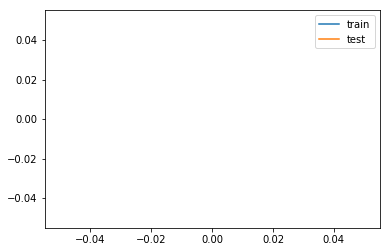

In [56]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()